# Data exploration

In [1]:
import csv
import h5py
import json

import cv2
import math
import numpy as np

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pylab
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.image as mpimg

import seaborn as sns; 
sns.set(color_codes=True)

matplotlib.pylab.rcParams['figure.figsize'] = (18, 12)
matplotlib.pylab.rcParams['agg.path.chunksize'] = 10000

In [3]:
# Load simulation data.
filename = './data/4/dataset.npz'
data = np.load(filename)
images = data['images']

(95, 320, 3)


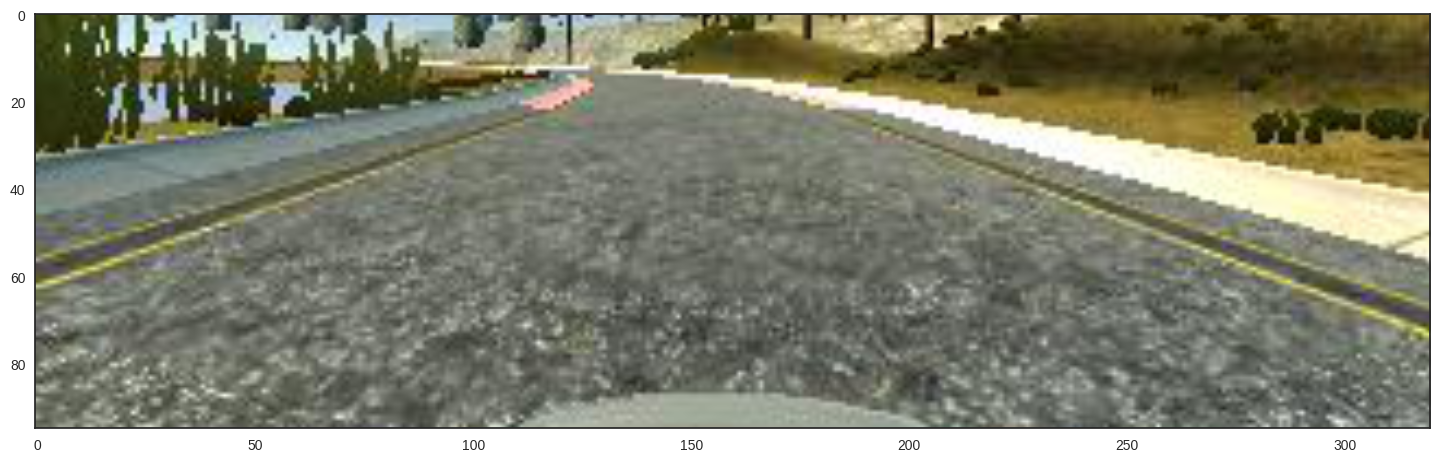

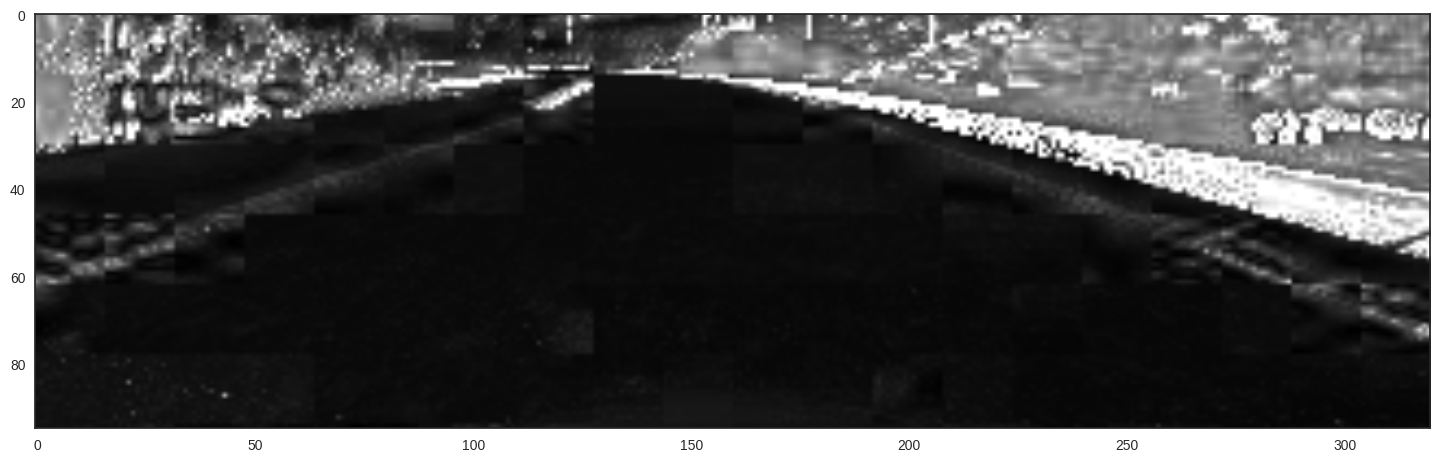

(95, 320, 3)


In [4]:
image = images[600,:,:,:]
out = image
# out = cv2.resize(image, (200, 100), interpolation=cv2.INTER_LANCZOS4)
# out = cv2.resize(image, (200, 100), interpolation=cv2.INTER_CUBIC) 
out = out[50:-15,:,:]
print(out.shape)

out_hls = cv2.cvtColor(out, cv2.COLOR_BGR2HLS)

with sns.axes_style("white"):
    plt.imshow(out)
    plt.show()

with sns.axes_style("white"):
    plt.imshow(out_hls[:,:,2], cmap='gray')
    plt.show()

print(out.shape)

In [5]:
# Pre-process images.
# images = images.astype(np.float32) / 255.
# images = 2. * images - 1.

# angle = data['angle']

In [6]:
# Load CSV file
filename = './data/5/driving_log.csv'
# filename = './data/50Hz_driving_log.csv'
with open(filename, 'r') as f:
    creader = csv.reader(f)
    csv_list = list(creader)
    
    # Read angle.
    angle_raw = np.array([float(a[3]) for a in csv_list], dtype=np.float32)
    
    # Speed: convert to m/s.
    speed = np.array([float(a[6]) for a in csv_list], dtype=np.float32)
    speed = speed * 1.609344 / 3.6
    
    # Time difference
    dt_array = np.ones_like(angle_raw) * 0.1
    for i in range(len(csv_list)-1):
        p0 = csv_list[i][0][:-4].split("_")
        p1 = csv_list[i+1][0][:-4].split("_")
        
        t0 = float(p0[-1])* 0.001 + float(p0[-2]) + float(p0[-3]) * 60. + float(p0[-4]) * 3600.
        t1 = float(p1[-1])* 0.001 + float(p1[-2]) + float(p1[-3]) * 60. + float(p1[-4]) * 3600.
        
        dt_array[i] = t1 - t0
        

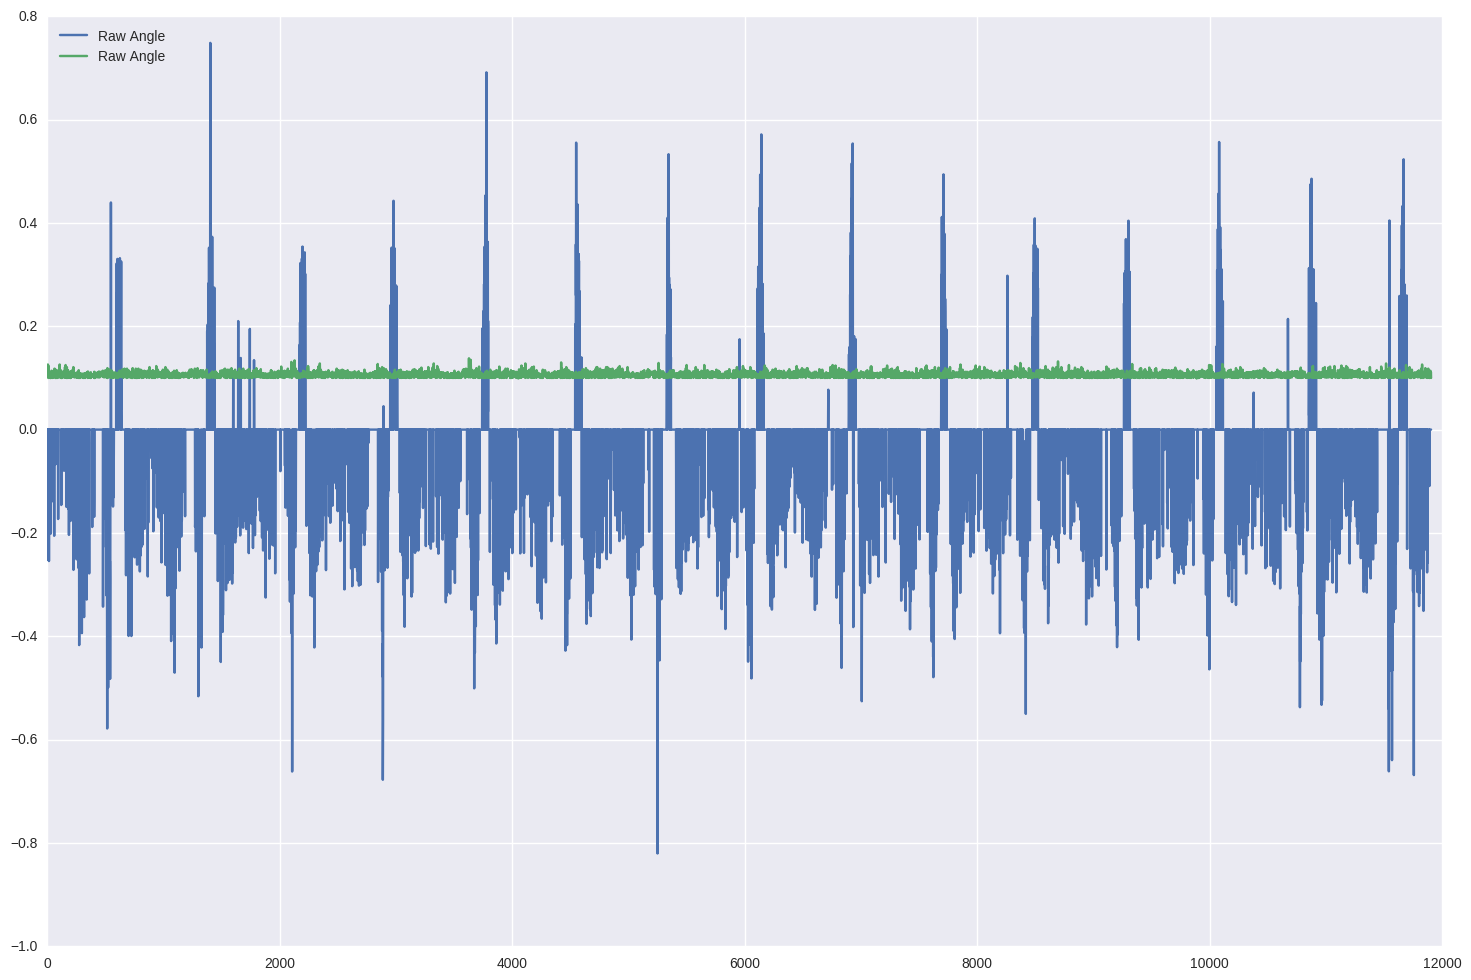

In [7]:
plt.plot(angle_raw, label='Raw Angle')
plt.plot(dt_array, label='Raw Angle')

# plt.plot(data['angle_sth16'], label='Post-smooth16')
# plt.plot(data['angle_rsth16'], label='Pre-smooth16')
# plt.plot(data['angle_pre6'], label='Pre-avg6')

plt.legend(loc='upper left')
plt.show()

In [8]:
def sinc(alpha):
    y = np.ones_like(alpha)
    mask = alpha != 0.0 
    y[mask] = np.sin(alpha[mask]) / alpha[mask]
    return y

def cosc(alpha):
    y = np.zeros_like(alpha)
    mask = alpha != 0.0 
    y[mask] = (1. - np.cos(alpha[mask])) / alpha[mask]
    return y


In [9]:
# Constant: frequency, speed and car length
dt = 0.1
dt = 0.02
# dt_array[:] = 0.1

CAR_LENGTH = 5.9
print(np.mean(dt_array))


0.106398


In [10]:
def trajectory(dt, speed, angle, length=CAR_LENGTH):
    # speed = 48.28032 * 1000 / 3600

    # Rotation radius
    # radius = length / np.sin(angle)
    alpha = speed * dt / length * np.sin(angle)

    # dx displacement vectors.
    dx = np.zeros(shape=(len(angle), 2), dtype=np.float32)
    dx[:, 0] = speed * dt * cosc(alpha)
    dx[:, 1] = speed * dt * sinc(alpha)
    # dx[:, 2] = 1.0

    # Affine transformation.
    rot_trans = np.zeros(shape=(len(angle), 2, 2), dtype=np.float32)
    rot_trans[:, 0, 0] = np.cos(alpha)
    rot_trans[:, 1, 1] = np.cos(alpha)
    rot_trans[:, 0, 1] = np.sin(alpha)
    rot_trans[:, 1, 0] = -np.sin(alpha)

    # Compute position vector of the car.
    x = np.zeros(shape=(len(angle), 2), dtype=np.float32)
    v1 = np.array([1., 0.], dtype=np.float32)
    v2 = np.array([0., 1.], dtype=np.float32)
    
    cum_rot_trans = rot_trans.copy()
    # unit_vectors = np.zeros(shape=(len(angle), 2), dtype=np.float32)

    for i in range(len(angle)-1):
        x[i+1] = x[i]
        x[i+1] += v1 * dx[i, 0]
        x[i+1] += v2 * dx[i, 1]
        
        v1 = np.matmul(rot_trans[i], v1)
        v2 = np.matmul(rot_trans[i], v2)

    return x, alpha

In [11]:
x, alpha = trajectory(dt_array, speed, angle_raw, length=5.9)

In [12]:
def angle_post(alpha, dt, speed, delta=1, offset=0.0, length=CAR_LENGTH):
    # Rotation radius
    # radius = length / np.sin(angle)
    # alpha = speed * dt / length * np.sin(angle)

    # Rotation matrices.
    rot_mat = np.zeros(shape=(len(alpha), 2, 2), dtype=np.float32)
    rot_mat[:, 1, 1] = np.cos(alpha)
    rot_mat[:, 0, 0] = np.cos(alpha)
    rot_mat[:, 0, 1] = np.sin(alpha)
    rot_mat[:, 1, 0] = -np.sin(alpha)
    
    # dx displacement vectors.
    dx = np.zeros(shape=(len(alpha), 2), dtype=np.float32)
    dx[:, 0] = speed * dt * cosc(alpha)
    dx[:, 1] = speed * dt * sinc(alpha)
    steps = np.ones(shape=(len(alpha), ), dtype=np.int8)
    
    # Local coordinate system. TODO: dense matrix notation...
    ax = np.zeros(shape=(len(alpha), 2, 1), dtype=np.float32)
    ay = np.zeros(shape=(len(alpha), 2, 1), dtype=np.float32)
    ax[:, 0, 0] = ay[:, 1, 0] = 1.0
    ax = np.matmul(rot_mat, ax)
    ay = np.matmul(rot_mat, ay)
    
    # Delta - Cumulative transformations and dx.
    cumul_dx = dx.copy()
    for j in range(1, delta):
        # Update cumulative dx.
        cumul_dx[:-j, 0] += dx[j:, 0] * ax[:-j, 0, 0]
        cumul_dx[:-j, 1] += dx[j:, 0] * ax[:-j, 1, 0]

        cumul_dx[:-j, 0] += dx[j:, 1] * ay[:-j, 0, 0]
        cumul_dx[:-j, 1] += dx[j:, 1] * ay[:-j, 1, 0]
        
        # Update local coordinate system.
        ax[:-j] = np.matmul(rot_mat[j:], ax[:-j])
        ay[:-j] = np.matmul(rot_mat[j:], ay[:-j])
        steps[:-j] += 1
        
    # Fit a Bezier curve! See: https://en.wikipedia.org/wiki/B%C3%A9zier_curve
    P0 = np.zeros(shape=(len(alpha), 2), dtype=np.float32)
    P0[:, 0] = offset
    P3 = cumul_dx
    P1 = P0.copy()
    P2 = P3.copy()
    
    # Vertical displacement... 1/3 factor coming from speed normalisation.
    factor = 0.3333
    P1[:, 1] += dt * speed * steps * factor
    # Same for P2...
    ay = np.squeeze(ay)
    P2[:, 0] += dt * speed * steps * (-ay[:, 0]) * factor
    P2[:, 1] += dt * speed * steps * (-ay[:, 1]) * factor
    
    # Check control points for licit values...
    mask = (P3[:, 0] > P0[:, 0]) * (P2[:, 0] < P0[:, 0])
    P2[mask, 0] = P0[mask, 0]
    mask = (P3[:, 0] < P0[:, 0]) * (P2[:, 0] > P0[:, 0])
    P2[mask, 0] = P0[mask, 0]
    mask = (P3[:, 1] > 0.) * (P2[:, 1] < 0.)
    P2[mask, 1] = 0.0
    mask = (P3[:, 1] < 0.) * (P2[:, 1] > 0.)
    P2[mask, 1] = 0.0
    
    mask = (P1[:, 1] > P3[:, 1])
    P1[mask, 1] = P3[mask, 1]
    
    # Inverse curvature at zero.
    dvx = (P1 - P0) / factor
    ddvx = 2 * (P2 - 2*P1 + P0) / factor
    
    kappa = -(ddvx[:, 1] * dvx[:, 0] - ddvx[:, 0] * dvx[:, 1]) / ((dvx[:, 0]**2 + dvx[:, 1]**2) ** 1.5)
    angle = np.arcsin(kappa * length)
         
    # Parameters in equation: ax - b = 0.
#     a = np.squeeze(ay)
#     b = a[:, 0] * cumul_dx[:, 0] + a[:, 1] * cumul_dx[:, 1]
#     # Inverse radius and angle.
#     inv_radius = a[:, 0] / ( b - a[:, 0] * offset )
#     angle = np.arcsin(inv_radius * length)
        
    return angle, kappa


def angle_post_mean(alpha, dt, speed, deltas=None, length=CAR_LENGTH):
    deltas = deltas or [1]
    
    avg = np.zeros(shape=(len(alpha),), dtype=np.float32)
    for d in deltas:
        a, kappa = angle_post(alpha, dt_array, speed, delta=d, length=length)
        avg += a
    avg = avg / len(deltas)
    return avg

In [13]:
a, kappa = angle_post(alpha, dt_array, speed, delta=10, length=5.9)

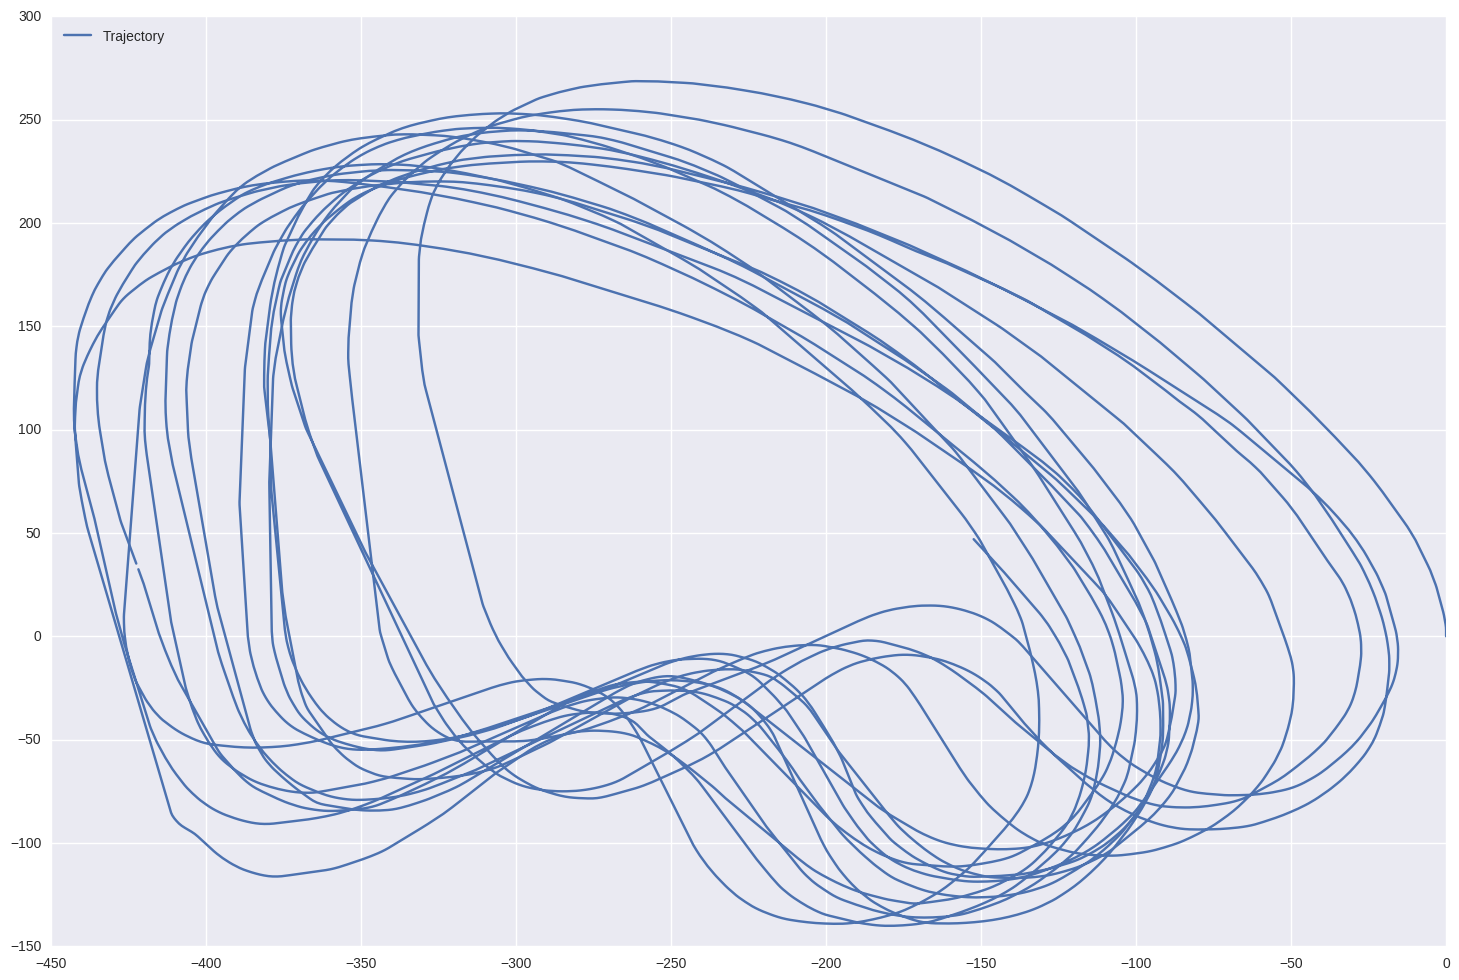

In [14]:
nb = 1000000

plt.plot(x[:nb, 0], x[:nb, 1], label='Trajectory')
# plt.plot(x2[:nb, 0], x2[:nb, 1], label='Trajectory 2')
# plt.plot(data['angle_sth16'], label='Post-smooth16')
# plt.plot(data['angle_rsth16'], label='Pre-smooth16')
# plt.plot(data['angle_pre6'], label='Pre-avg6')

plt.legend(loc='upper left')
plt.show()

In [15]:
def deriv_middle(x, delta):
    """Compute derivative with zero padding.
    """
    dx = x[2*delta:] - x[:-2*delta]
    dx = np.lib.pad(dx, ((delta, delta), (0, 0)), 'symmetric')
    return dx / 2.


def deriv_forward(x, delta):
    """Compute derivative with zero padding.
    """
    dx0 = x[2*delta:] - x[:-2*delta]
    dx0 = np.lib.pad(dx0, ((0, 2 * delta), (0, 0)), 'symmetric')
    dx1 = x[delta:] - x[:-delta]
    dx1 = np.lib.pad(dx1, ((0, delta), (0, 0)), 'symmetric')
    
    return 2 * dx1 - 0.5 * dx0


def angle_curvature(x, delta=1, deriv=deriv_middle, length=5.9):
    # First and second derivative...
    dvx = deriv(x, delta)
    ddvx = deriv(dvx, delta)
    # Inverse curvature.
    kappa = (ddvx[:,1] * dvx[:,0] - ddvx[:,0] * dvx[:,1]) / ((dvx[:, 0]**2 + dvx[:, 1]**2) ** 1.5)
    angle = np.arcsin(-kappa * length)
    return angle

angle_cv2 = angle_curvature(x, delta=2)
angle_cv3 = angle_curvature(x, delta=3)
angle_cv4 = angle_curvature(x, delta=4)
angle_cv8 = angle_curvature(x, delta=8)

# angle_fcv2 = angle_curvature(x, delta=2, deriv=deriv_forward)
# angle_fcv4 = angle_curvature(x, delta=4, deriv=deriv_forward)
# angle_fcv8 = angle_curvature(x, delta=8, deriv=deriv_forward)

angle_fcv5, _ = angle_post(alpha, dt_array, speed, delta=5, length=5.9)
angle_fcv10, _ = angle_post(alpha, dt_array, speed, delta=10, length=5.9)
angle_fcv15, _ = angle_post(alpha, dt_array, speed, delta=15, length=5.9)
angle_fcv20, _ = angle_post(alpha, dt_array, speed, delta=20, length=5.9)
angle_fcv40, _ = angle_post(alpha, dt_array, speed, delta=40, length=5.9)
angle_fcv60, _ = angle_post(alpha, dt_array, speed, delta=60, length=5.9)

angle_fcv402, _ = angle_post(alpha, dt_array, speed, delta=40, length=5.9, offset=2.)

angle_mfcv4 = angle_post_mean(alpha, dt_array, speed, deltas=[3, 4, 5], length=5.9)
angle_mfcv8 = angle_post_mean(alpha, dt_array, speed, deltas=[10, 15, 20, 25], length=5.9)



/home/paul/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:74: RuntimeWarning: invalid value encountered in arcsin


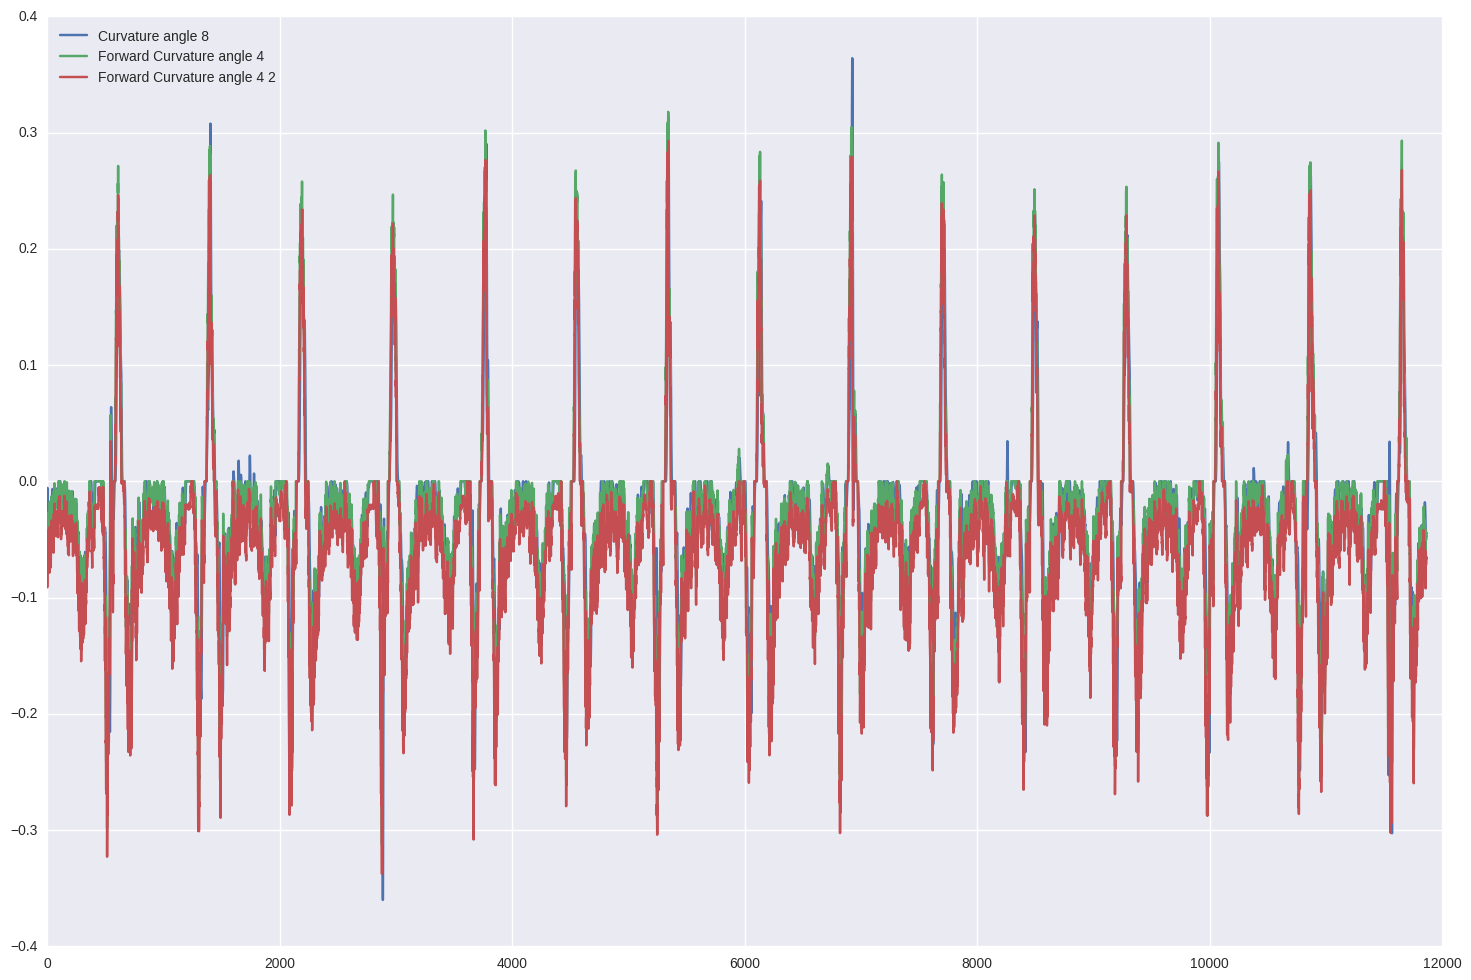

In [21]:
nb = -40

# plt.plot(angle_raw[:nb], label='Raw Angle')
# plt.plot(angle_cv1[:nb], label='Curvature angle 1')
# plt.plot(angle_cv4[:nb], label='Curvature angle 2')
# plt.plot(angle_cv4[:nb], label='Curvature angle 4')
plt.plot(angle_cv4[:nb], label='Curvature angle 8')

plt.plot(angle_fcv40[:nb], label='Forward Curvature angle 4')
plt.plot(angle_fcv402[:nb], label='Forward Curvature angle 4 2')

# plt.plot(angle_fcv24[:nb], label='Forward Curvature angle 8')
# plt.plot(angle_mfcv4[:nb], label='Forward Curvature angle 4')
# plt.plot(angle_mfcv8[:nb], label='Forward Curvature angle 8')

plt.legend(loc='upper left')
plt.show()

In [17]:
dt_array

array([ 0.108,  0.105,  0.11 , ...,  0.111,  0.111,  0.1  ], dtype=float32)

In [18]:
2**1.2

2.2973967099940698

In [38]:
# Load simulation data.
filename = './data/q3_clean/dataset.npz'
data = np.load(filename)
images = data['images']
angle_raw = data['angle']

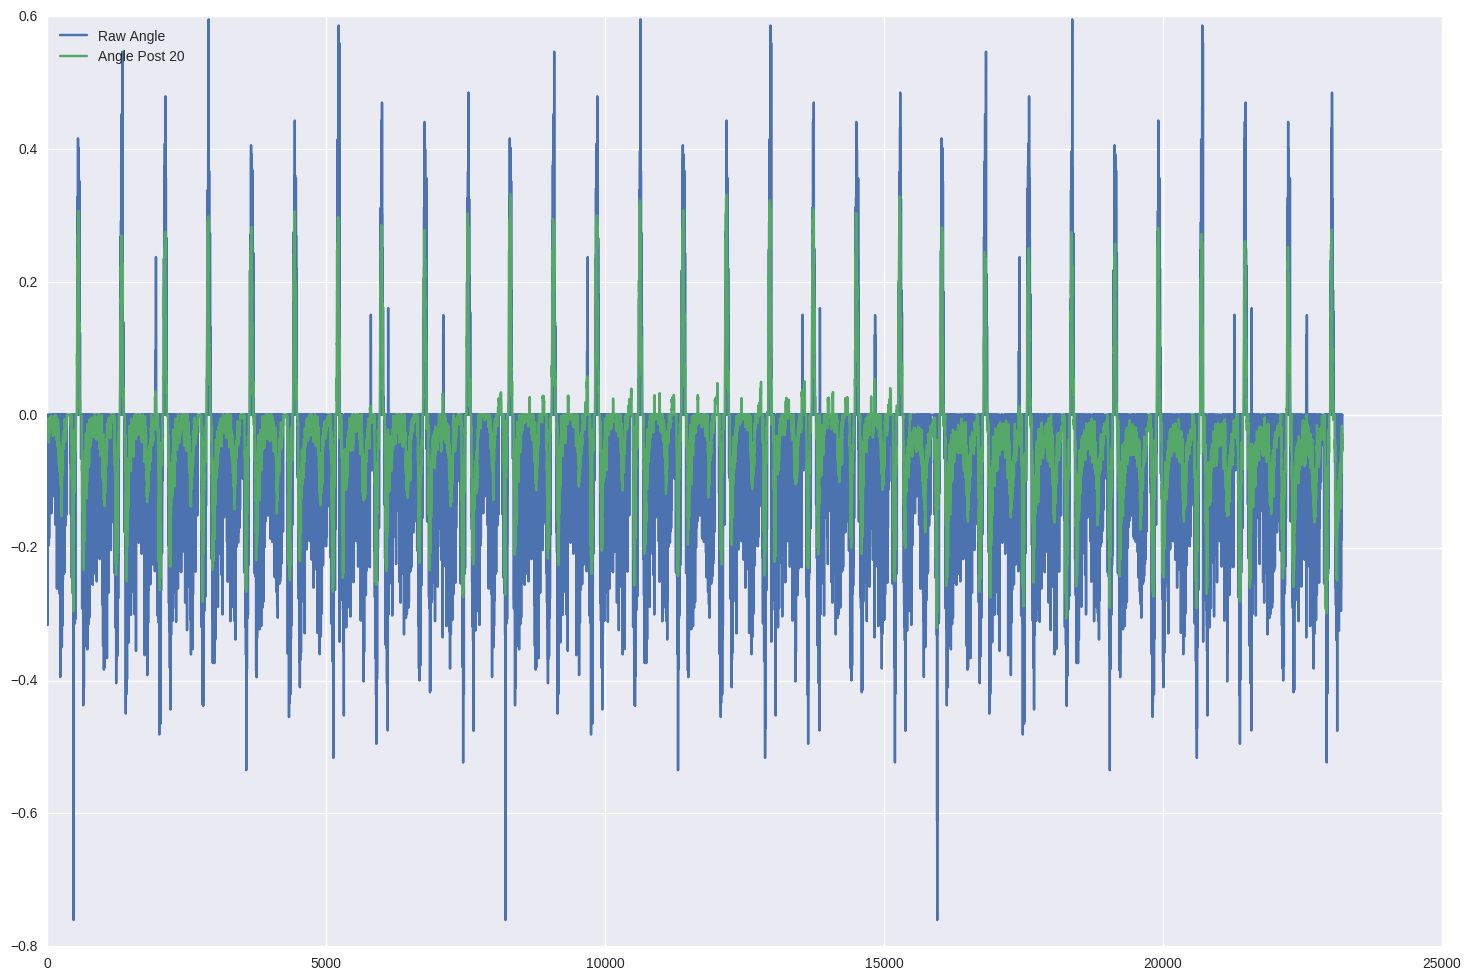

In [41]:
nb = -1

plt.plot(angle_raw[:nb], label='Raw Angle')

plt.plot(data['angle_post40'][:nb], label='Angle Post 20')
# plt.plot(angle_cv4[:nb], label='Curvature angle 8')

# plt.plot(angle_fcv40[:nb], label='Forward Curvature angle 4')
# plt.plot(angle_fcv402[:nb], label='Forward Curvature angle 4 2')

# plt.plot(angle_fcv24[:nb], label='Forward Curvature angle 8')
# plt.plot(angle_mfcv4[:nb], label='Forward Curvature angle 4')
# plt.plot(angle_mfcv8[:nb], label='Forward Curvature angle 8')

plt.legend(loc='upper left')
plt.show()

In [28]:
angle_raw[-20:]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.19485641,  0.        ,  0.        ,
        0.        ,  0.03581429,  0.34875011,  0.00226164,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ], dtype=float32)

12